In [1]:
import sys
print(sys.version)
import os
os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ['TF_USE_LEGACY_KERAS'] = "1"

3.11.4 (main, Jul  5 2023, 13:45:01) [GCC 11.2.0]


In [2]:
import datetime
import copy
import torch
import logging
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random as python_random
import tensorflow as tf
from bs4 import BeautifulSoup
import xml.etree.ElementTree as Xet
from argparse import ArgumentParser
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATSx
from neuralforecast.losses.pytorch import MQLoss
from sklearn.preprocessing import MinMaxScaler
from nbeats_pytorch.model import NBeatsNet
from sklearn.neighbors import NearestNeighbors
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from tensorflow.keras.models import Sequential


2024-12-15 13:35:45.036955: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1734266145.103446   71006 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734266145.123878   71006 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-15 13:35:45.189681: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/torch/cuda/__init__.py:628: UserWarning: Can't initialize NVML
  war

In [3]:
class DataLoader:
    """
    Load data into desired formats for training/validation/testing, including preprocessing.
    """

    def __init__(self, horizon, back_horizon):
        self.horizon = horizon
        self.back_horizon = back_horizon
        self.scaler = list()
        self.historical_values = list()  # first by patient idx, then by col_idx

    def preprocessing(
        self,
        lst_train_arrays,
        lst_test_arrays,
        # train_mode=True, # flag for train_mode (split into train/val), test_mode (no split)
        train_size=0.8,
        normalize=False,
        sequence_stride=6,
        target_col=0,
        horizon=12
    ):
        self.normalize = normalize
        self.sequence_stride = sequence_stride
        self.target_col = target_col
        train_arrays = copy.deepcopy(lst_train_arrays)
        test_arrays = copy.deepcopy(lst_test_arrays)
        # count valid timesteps for each individual series
        # train_array.shape = n_timesteps x n_features
        self.valid_steps_train = [train_array.shape[0] for train_array in train_arrays]
        train_lst, val_lst, test_lst = list(), list(), list()
        for idx in range(len(train_arrays)):
            print(idx, "index")
            bg_sample_train = train_arrays[idx]
            #bg_sample_train_exog = np.delete(train_arrays[idx], 0, 1)
            bg_sample_test = test_arrays[idx]#[:, target_col]
            #bg_sample_test_exog = np.delete(test_arrays[idx], 0, 1)
            valid_steps_sample = self.valid_steps_train[idx]
            #train_target = bg_sample_train_target[: int(train_size * valid_steps_sample)].copy()
            train = bg_sample_train[: int(train_size * valid_steps_sample), :].copy()
            #val_target = bg_sample_train_target[int(train_size * valid_steps_sample) :].copy()
            val = bg_sample_train[int(train_size * valid_steps_sample) :, :].copy()
            #test_target = bg_sample_test_target[:].copy()
            test = bg_sample_test[:, :].copy()
            if self.normalize:
                scaler_cols = list()
                # train.shape = n_train_timesteps x n_features
                for col_idx in range(train.shape[1]):
                    scaler = MinMaxScaler(feature_range=(0, 1), clip=False)
                    train[:, col_idx] = remove_extra_dim(
                        scaler.fit_transform((add_extra_dim(train[:, col_idx])))
                    )
                    val[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(val[:, col_idx]))
                    )
                    test[:, col_idx] = remove_extra_dim(
                        scaler.transform(add_extra_dim(test[:, col_idx]))
                    )
                    scaler_cols.append(scaler)  # by col_idx, each feature
                self.scaler.append(scaler_cols)  # by pat_idx, each patient
                
            lst_hist_values = list()
            for col_idx in range(train.shape[1]):
                all_train_col = np.concatenate((train[:, col_idx], val[:, col_idx]))
                # decimals = 1, 2 OR 3?
                unique_values = np.unique(np.round(all_train_col, decimals=2))
                lst_hist_values.append(unique_values)
            self.historical_values.append(lst_hist_values)

            train_lst.append(train)
            #train_lst_exog.append(train_exog)
            val_lst.append(val)
            #val_lst_exog.append(val_exog)
            test_lst.append(test)
            #test_lst_exog.append(test_exog)
        

        (
            self.X_train_exog,
            self.X_train_target,
            self.Y_train,
            self.train_idxs,
        ) = self.create_sequences(
            train_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_val_exog,
            self.X_val_target,
            self.Y_val,
            self.val_idxs,
        ) = self.create_sequences(
            val_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        (
            self.X_test_exog,
            self.X_test_target,
            self.Y_test,
            self.test_idxs,
        ) = self.create_sequences(
            test_lst,
            self.horizon,
            self.back_horizon,
            self.sequence_stride,
            self.target_col,
        )
        
    @staticmethod
    def create_sequences(
        series_lst, horizon, back_horizon, sequence_stride, target_col=0, exog=False
    ):
        Xs_exog, Xs_target, Ys, sample_idxs = list(), list(), list(), list()
        
        cnt_nans = 0
        for idx, series in enumerate(series_lst):
            len_series = series.shape[0]
            if len_series < (horizon + back_horizon):
                print(
                    f"Warning: not enough timesteps to split for sample {idx}, len: {len_series}, horizon: {horizon}, back: {back_horizon}."
                )
            for i in range(0, len_series - back_horizon - horizon, sequence_stride):
                input_series_exog = series[i : (i + back_horizon)]
                input_series_exog = np.delete(input_series_exog, [target_col], axis=1)
                input_series_target = series[i : (i + back_horizon), [target_col]]
                output_series = series[
                    (i + back_horizon) : (i + back_horizon + horizon), [target_col]
                ]
                # TODO: add future plans as additional variables (?)
                if np.isfinite(input_series_exog).all() and np.isfinite(input_series_target).all() and np.isfinite(output_series).all():
                    Xs_exog.append(input_series_exog)
                    Xs_target.append(input_series_target)
                    Ys.append(output_series)
                    # record the sample index when splitting
                    sample_idxs.append(idx)
                else:
                    cnt_nans += 1
                    if cnt_nans % 100 == 0:
                        print(f"{cnt_nans} strides skipped due to NaN values.")
        #print("train", np.array(Xs), "test", np.array(Ys), "val", np.array(sample_idxs))
        return np.array(Xs_exog), np.array(Xs_target), np.array(Ys), np.array(sample_idxs)


In [4]:
# remove an extra dimension
def remove_extra_dim(input_array):
    # 2d to 1d
    if len(input_array.shape) == 2:
        return np.reshape(input_array, (-1))
    # 3d to 2d (remove the last empty dim)
    elif len(input_array.shape) == 3:
        return np.squeeze(np.asarray(input_array), axis=-1)
    else:
        print("Not implemented.")
        #print(input_array, "JLNA;iknb")

# add an extra dimension
def add_extra_dim(input_array):
    # 1d to 2d
    if len(input_array.shape) == 1:
        return np.reshape(input_array, (-1, 1))
    # 2d to 3d
    elif len(input_array.shape) == 2:
        return np.asarray(input_array)[:, :, np.newaxis]
    else:
        print("Not implemented.")
        #print(input_array, "ALVNAPNV")

# Method: Fix the random seeds to get consistent models
def reset_seeds(seed_value=39):
    # ref: https://keras.io/getting_started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development
    os.environ["PYTHONHASHSEED"] = str(seed_value)
    # necessary for starting Numpy generated random numbers in a well-defined initial state.
    np.random.seed(seed_value)
    # necessary for starting core Python generated random numbers in a well-defined state.
    python_random.seed(seed_value)
    # set_seed() will make random number generation
    tf.random.set_seed(seed_value)  

In [5]:
def prepare_data(dataset, data_path):
    df = []
    df = pd.DataFrame(df)
    if dataset == "simulated":
        for i,j in zip(["01","02","03","04","05","06","07","08","09","10"],[1,2,3,4,5,6,7,8,9,10]):
            a = pd.read_csv(f"../results/simulation_4/adult#0{i}.csv")
            a["Time"] = a[["Time"]].apply(
                lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
            )
            #a['Time'] = pd.to_datetime(a['Time'])
            #a.rename(columns={"Time":"ds", "BG":"y"}, inplace=True)
            a = a.dropna()
            #date_index = pd.date_range(a.Time[0], periods=len(a),freq='3min')
            #a.index = date_index
            a['patient_id'] = pd.Series([f"{j}" for x in range(len(a.index))])
            df = pd.concat([df,a], ignore_index=True)
        
        #df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        print("aldingvapnb[", df)
        idx = int( df.shape[0] * 0.8)#TEST_SIZE)
        cut = int((df.shape[0]-idx)/10)
        Y_train_df = df[df.CGM<df['CGM'].values[-cut]] # 132 train
        Y_test_df = df[df.CGM>=df['CGM'].values[-cut]].reset_index(drop=True) # 12 test  
        Y_train_df.to_csv("data/data_simulation/all_train.csv")
        Y_test_df.to_csv("data/data_simulation/all_test.csv")
        df.drop(['Time','BG','LBGI','HBGI','Risk'], axis=1, inplace=True)
        #return df
        
    elif dataset == "ohiot1dm":
        train = []
        test = []
        train = pd.DataFrame(train)
        test = pd.DataFrame(test)
        for i in [540, 544, 552, 567, 584, 596, 559, 563, 570, 575, 588, 591]:
            file_train = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_train.csv")
            file_test = pd.read_csv(data_path + "data_OhioT1DM/" + f"{i}_test.csv")
            
            file_train['patient_id'] = pd.Series([f"{i}" for x in range(len(file_train.index))])
            file_test['patient_id'] = pd.Series([f"{i}" for x in range(len(file_test.index))])
            
            train = pd.concat([train, file_train], ignore_index=True)
            test = pd.concat([train, file_test], ignore_index=True)
            
        train.to_csv(data_path + "data_OhioT1DM/all_train.csv")
        test.to_csv(data_path + "data_OhioT1DM/all_test.csv")
        

In [6]:
def load_data(dataset, data_path):
    prepare_data(dataset, data_path)
    if dataset == "ohiot1dm":
        train, orig_train = load_ohio_data(data_path, "all_train.csv")
        test, orig_test = load_ohio_data(data_path, "all_test.csv")
    elif dataset == "simulated":
        #idx = int( df.shape[0] * 1-TEST_SIZE )
        #cut = int((df.shape[0]-idx)/10)
        #train = df[df.CGM<df['CGM'].values[-cut]] # 132 train
        #test = df[df.CGM>=df['CGM'].values[-cut]].reset_index(drop=True) # 12 test  
        train, orig_train = load_sim_data(data_path, "all_train.csv")
        test, orig_test = load_sim_data(data_path, "all_test.csv")
    else:
        print("No dataset chosen")
    return train, test, orig_train, orig_test

def load_ohio_data(data_path, file_name="all_train.csv"):
    # load all the patients, combined
    data = pd.read_csv(data_path + "data_OhioT1DM/" + file_name)

    from functools import reduce
    from operator import or_ as union

    def idx_union(mylist):
        idx = reduce(union, (index for index in mylist))
        return idx

    idx_missing = data.loc[data["missing"] != -1].index
    idx_missing_union = idx_union([idx_missing - 1, idx_missing])

    data = data.drop(idx_missing_union)
    data_bg = data[
        [
            "index_new",
            "patient_id",
            "glucose",
            "basal",
            "bolus",
            "carbs",
            "exercise_intensity",
        ]
    ]
    data_bg["time"] = data_bg[["index_new"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("index_new", axis=1)

    data_bg["bolus"][data_bg["bolus"] == -1] = 0
    data_bg["carbs"][data_bg["carbs"] == -1] = 0
    data_bg["exercise_intensity"][data_bg["exercise_intensity"] == -1] = 0
    data_bg["glucose"][data_bg["glucose"] == -1] = np.NaN

    lst_patient_id = [
        540,
        544,
        552,
        567,
        584,
        596,
        559,
        563,
        570,
        575,
        588,
        591,
    ]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][
                    [
                        "glucose",
                        "basal",
                        "bolus",
                        "carbs",
                        "exercise_intensity",
                    ]
                ]
            )
        )
    return lst_arrays, data_bg


def load_sim_data(data_path, file_name="all_train.csv"):
    data = pd.read_csv(data_path + "data_simulation/" + file_name)
    data_bg = data[["patient_id", "Time", "CGM", "CHO", "insulin"]]
    #print(data_bg)
    data_bg["time"] = data_bg[["Time"]].apply(
        lambda x: pd.to_datetime(x, errors="coerce", format="%Y-%m-%d %H:%M:%S")
    )
    data_bg = data_bg.drop("Time", axis=1)
    lst_patient_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    lst_arrays = list()
    for pat_id in lst_patient_id:
        lst_arrays.append(
            np.asarray(
                data_bg[data_bg["patient_id"] == pat_id][["CGM", "CHO", "insulin"]]
            )
        )
    return lst_arrays, data_bg
    

In [30]:
def forecast_metrics(dataset, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
            idx = dataset.test_idxs[i]
            scaler = dataset.scaler[idx]

            Y_test_original.append(
                scaler[dataset.target_col].inverse_transform(dataset.X_test_target[i])
            )
            Y_pred_original.append(
                scaler[dataset.target_col].inverse_transform(Y_pred[i])
            )

        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse

def forecast_metrics_single(Y_orig, Y_pred, inverse_transform=True):
    Y_test_original, Y_pred_original = list(), list()
    #Y_pred = np.squeeze(Y_pred, axis=-1)
    if inverse_transform:
        #for i in range(dataset.X_test_exog.shape[0]):
            #print("Y_test", dataset.Y_test[i], "Y_pred", Y_pred[i])
        #    idx = dataset.test_idxs[i]
        scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
        
        Y_test_original = scaler.inverse_transform(Y_orig)  # Ensure correct shape
        Y_pred_original = scaler.inverse_transform(Y_pred.numpy().reshape(-1, 1))  # Ensure correct shape


        Y_test_original = np.array(Y_test_original)
        Y_pred_original = np.array(Y_pred_original)
    else:
        Y_test_original = dataset.X_test_target
        Y_pred_original = Y_pred

    def smape(Y_test, Y_pred):
        # src: https://github.com/ServiceNow/N-BEATS/blob/c746a4f13ffc957487e0c3279b182c3030836053/common/metrics.py
        def smape_sample(actual, forecast):
            return 200 * np.mean(
                np.abs(forecast - actual) / (np.abs(actual) + np.abs(forecast))
            )

        return np.mean([smape_sample(Y_test[i], Y_pred[i]) for i in range(len(Y_pred))])

    def rmse(Y_test, Y_pred):
        return np.sqrt(np.mean((Y_pred - Y_test) ** 2))
    print("test", Y_test_original, "pred", Y_pred_original)
    mean_smape = smape(Y_test_original, Y_pred_original)
    mean_rmse = rmse(Y_test_original, Y_pred_original)

    return mean_smape, mean_rmse


def polynomial_values(shift, change_percent, poly_order, horizon, desired_steps=None):
    """
    shift: e.g., +0.1 (110% of the start value)
    change_percent: e.g., 0.1 (10% increase)
    poly_order: e.g., order 1, or 2, ...
    horizon: the forecasting horizon
    desired_steps: the desired timesteps for the change_percent to finally happen (can be larger than horizon)
    """
    if horizon == 1:
        return np.asarray([shift + change_percent])
    desired_steps = desired_steps if desired_steps else horizon

    p_orders = [shift]  # intercept
    p_orders.extend([0 for i in range(poly_order)])
    p_orders[-1] = change_percent / ((desired_steps - 1) ** poly_order)

    p = np.polynomial.Polynomial(p_orders)
    p_coefs = list(reversed(p.coef))
    value_lst = np.asarray([np.polyval(p_coefs, i) for i in range(desired_steps)])

    return value_lst[:horizon]


def generate_bounds(
    center,
    shift,
    desired_center,
    poly_order,
    horizon,
    fraction_std,
    input_series,
    desired_steps,
):
    if center == "last":
        start_value = input_series[-1]
    elif center == "median":
        start_value = np.median(input_series)
    elif center == "mean":
        start_value = np.mean(input_series)
    elif center == "min":
        start_value = np.min(input_series)
    elif center == "max":
        start_value = np.max(input_series)
    else:
        print("Center: not implemented.")

    std = np.std(input_series)
    # Calculate the change_percent based on the desired center (in 2 hours)
    change_percent = (desired_center - start_value) / start_value
    # Create a default fluctuating range for the upper and lower bound if std is too small
    fluct_range = fraction_std * std if fraction_std * std >= 0.025 else 0.025
    upper = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            + fluct_range
        )
    )
    lower = add_extra_dim(
        start_value
        * (
            1
            + polynomial_values(
                shift, change_percent, poly_order, horizon, desired_steps
            )
            - fluct_range
        )
    )

    return upper, lower

In [14]:
parser = ArgumentParser()
parser.add_argument( "--dataset", type=str, help="Choose dataset.")
parser.add_argument( "--horizon", type=int, help="Horizon of forecasting task.")
parser.add_argument( "--back-horizon", type=int, help="Back horizon of forecasting task.")
parser.add_argument( "--random-seed", type=int, default=39, help="Random seed parameter, default 39.")
parser.add_argument( "--train-size", type=float, default=0.8, help="Proportional size of the training set.")
parser.add_argument( "--test-group", type=str, default=None, help="Extract random 100 samples from test group, i.e., 'hyper'/'hypo'; default None.")
# Parse the arguments from a string
args = parser.parse_args("--dataset ohiot1dm --horizon 24 --back-horizon 24 --random-seed 35 --train-size 0.8".split())
#args = parser.parse_args()
data_path = "./data/"
lst_arrays, lst_arrays_test, orig_train, orig_test = load_data(args.dataset, data_path) #misschien toch load_data gebruiken?
print(f"The shape of loaded train: {len(lst_arrays)}*{lst_arrays[0].shape}")
print(f"The shape of test: {len(lst_arrays_test)}*{lst_arrays_test[0].shape}")

print(f"===========Desired trend parameters=============")
center = "last"
desired_shift, poly_order = 0, 1
fraction_std = 1#args.fraction_std
print(f"center: {center}, desired_shift: {desired_shift};")
print(f"fraction_std:{fraction_std};")
print(f"desired_change:'sample_based', poly_order:{poly_order}.")

TARGET_COL = 0
if args.dataset == "ohiot1dm":
    CHANGE_COLS = [1, 2, 3, 4]
elif args.dataset == "simulated":
    CHANGE_COLS = [1, 2]
else:
    CHANGE_COLS = None

RANDOM_STATE = args.random_seed
TRAIN_SIZE = args.train_size
horizon, back_horizon = args.horizon, args.back_horizon
dataset = DataLoader(horizon, back_horizon)
dataset.preprocessing(#???
    lst_train_arrays=lst_arrays,
    lst_test_arrays=lst_arrays_test,
    train_size=TRAIN_SIZE,
    normalize=True,
    sequence_stride= horizon,
    target_col=TARGET_COL,
    horizon = horizon
)

#print(dataset.X_train.shape, dataset.Y_train.shape)
#print(dataset.X_val.shape, dataset.Y_val.shape)
#print(dataset.X_test.shape, dataset.Y_test.shape)


print(dataset.X_train_exog, dataset.X_train_target, dataset.X_train_exog.shape, dataset.X_train_target.shape)
X = dataset.X_train_exog
y = dataset.X_train_target
tf.random.set_seed(args.random_seed)
#tf_model = tf.keras.Sequential([
#    tf.keras.layers.Dense(64, activation='relu'),
#    tf.keras.layers.Dense(1)  # Assuming regression
#])

n_in_features = dataset.X_train_exog.shape[2]
n_out_features = 1
tf_model = tf.keras.models.Sequential(
    [
        tf.keras.layers.Input(shape=(back_horizon, n_in_features)),
        # Shape [batch, time, features] => [batch, time, gru_units]
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=True),
        tf.keras.layers.GRU(100, activation="tanh", return_sequences=False),
        # Shape => [batch, time, features]
        tf.keras.layers.Dense(horizon, activation="linear"),
        tf.keras.layers.Reshape((horizon, n_out_features)),
    ]
)
#orig_test_metric = np.asarray(orig_test.drop(['time'], axis=1))#[orig_test.patient_id==544], 'patient_id'
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001)
tf_model.compile(optimizer=optimizer, loss="mae")
#tf_model.compile(optimizer='adam', loss='mse')
tf_model.fit(X, y, epochs=100, verbose=0)
pred_tf = tf_model(dataset.X_test_exog)#[-horizon:])
mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf)
print(
    f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)
print(pred_tf)
#Welke vorm moet pred hebben???

/tmp/ipykernel_71006/3259339262.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["time"] = data_bg[["index_new"]].apply(
/tmp/ipykernel_71006/3259339262.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["bolus"][data_bg["bolus"] == -1] = 0
/tmp/ipykernel_71006/3259339262.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_bg["carbs"][data_bg["carbs"] 

The shape of loaded train: 12*(12236, 5)
The shape of test: 12*(12236, 5)
===========Desired trend parameters=============
center: last, desired_shift: 0;
fraction_std:1;
desired_change:'sample_based', poly_order:1.
0 index
1 index
2 index
3 index
4 index
5 index
6 index
7 index
8 index
9 index
10 index
11 index
100 strides skipped due to NaN values.
200 strides skipped due to NaN values.
300 strides skipped due to NaN values.
400 strides skipped due to NaN values.
500 strides skipped due to NaN values.
600 strides skipped due to NaN values.
700 strides skipped due to NaN values.
800 strides skipped due to NaN values.
900 strides skipped due to NaN values.
1000 strides skipped due to NaN values.
100 strides skipped due to NaN values.
200 strides skipped due to NaN values.
100 strides skipped due to NaN values.
200 strides skipped due to NaN values.
300 strides skipped due to NaN values.
400 strides skipped due to NaN values.
500 strides skipped due to NaN values.
600 strides skipped du

2024-12-15 13:57:19.051082: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}


test [[[ 65.]
  [ 63.]
  [ 66.]
  ...
  [129.]
  [127.]
  [124.]]

 [[123.]
  [124.]
  [126.]
  ...
  [ 77.]
  [ 73.]
  [ 72.]]

 [[ 71.]
  [ 66.]
  [ 60.]
  ...
  [126.]
  [118.]
  [109.]]

 ...

 [[ 66.]
  [ 80.]
  [ 95.]
  ...
  [147.]
  [150.]
  [152.]]

 [[154.]
  [157.]
  [160.]
  ...
  [193.]
  [193.]
  [192.]]

 [[191.]
  [192.]
  [192.]
  ...
  [208.]
  [200.]
  [197.]]] pred [[[195.84070677]
  [202.49780673]
  [202.29171619]
  ...
  [235.02836353]
  [208.27226382]
  [208.69542646]]

 [[115.2167424 ]
  [115.59441981]
  [116.49907482]
  ...
  [107.03743647]
  [108.21565978]
  [109.1570736 ]]

 [[121.58137989]
  [129.8837136 ]
  [118.43667299]
  ...
  [148.7524845 ]
  [153.26172864]
  [152.59424591]]

 ...

 [[153.12500906]
  [152.67253542]
  [155.06580114]
  ...
  [141.07402563]
  [141.64114475]
  [140.49186611]]

 [[153.12500906]
  [152.67253542]
  [155.06580114]
  ...
  [141.07402563]
  [141.64114475]
  [140.49186611]]

 [[167.55765247]
  [165.67250586]
  [171.64136076]
  ...

In [62]:
import tensorflow as tf
from nbeats_keras.model import NBeatsNet

# Prepare the data
X = dataset.X_train_exog  # Shape: (num_samples, back_horizon, num_features)
y = dataset.X_train_target  # Shape: (num_samples, horizon)

# Set random seed for reproducibility
tf.random.set_seed(args.random_seed)

# Define model hyperparameters
horizon, back_horizon = args.horizon, args.back_horizon

# Create the N-BEATSx model
nbeatsx_model = NBeatsNet(
    stack_types=(NBeatsNet.GENERIC_BLOCK, NBeatsNet.GENERIC_BLOCK),
    forecast_length=horizon,
    backcast_length=back_horizon,
    hidden_layer_units=256,
)

# Compile the model
nbeatsx_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="mae"
)

# Train the model
nbeatsx_model.fit(X, y, epochs=100, verbose=0)

# Make predictions
pred_nbeatsx = nbeatsx_model.predict(dataset.X_test_exog)  # Predictions on the test set
print(pred_nbeatsx)

2024-12-16 14:08:50.201798: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_17}}
2024-12-16 14:15:45.997789: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),

156/156 [==============================] - 4s 18ms/step
[[[0.10829307]
  [0.09837344]
  [0.1328608 ]
  ...
  [0.29508132]
  [0.26594257]
  [0.22990073]]

 [[0.26646215]
  [0.26404414]
  [0.2761548 ]
  ...
  [0.17744146]
  [0.19072016]
  [0.17071423]]

 [[0.11153011]
  [0.10324298]
  [0.0784109 ]
  ...
  [0.33868796]
  [0.37203145]
  [0.3535967 ]]

 ...

 [[0.35647693]
  [0.366659  ]
  [0.35426667]
  ...
  [0.33167237]
  [0.34150228]
  [0.33777672]]

 [[0.35647693]
  [0.366659  ]
  [0.35426667]
  ...
  [0.33167237]
  [0.34150228]
  [0.33777672]]

 [[0.35647693]
  [0.366659  ]
  [0.35426667]
  ...
  [0.33167237]
  [0.34150228]
  [0.33777672]]]


In [43]:
#nbeats
def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(
        reduction=tf.keras.losses.Reduction.SUM
    )
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss


targets_nbeats = np.empty(X_test.shape)
exogs_nbeats = np.empty(X_test.shape)
losses_nbeats = np.empty(X_test.shape[0])
max_bound_nbeats = np.empty(X_test.shape)
min_bound_nbeats = np.empty(X_test.shape)


for i in range(X_test.shape[0]):
    print(f"{i} samples been transformed.")
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )
    min_bound_nbeats[i] = min_bound
    max_bound_nbeats[i] = max_bound
    X = X_test[i]
    y = Y_test[i]
    X_test_exog = dataset.X_test_exog[i]
#X = dataset.X_train_exog
#X = random.choice(X)
#X = tf.Variable(tf.convert_to_tensor(X, dtype=tf.float32), dtype=tf.float32)

    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05,  epsilon=1e-07,)
    
    #nbeatsx_model.compile(optimizer=optimizer, loss="mae")
    #nbeatsx_model.fit(X, y, epochs=100, verbose=0)

    grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
    grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)
    
    with tf.GradientTape() as tape:
        tape.watch(grad_X_e)
        # Calculate the value of the function and record the gradient
        pred_nbeats = nbeatsx_model.predict(tf.expand_dims(grad_X_e, axis=0))
        pred_nbeats = tf.squeeze(pred_nbeats)
        loss = compute_loss(max_bound, min_bound, pred_nbeats)
        print(loss)
#pred = nbeatsx_model(grad_X_e)

    #if i == 0:
    #    mean_smape, mean_rmse = forecast_metrics(dataset, pred_nbeats)
    #    print(
    #        f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
    #    )
        
    max_iter = 100
    it = 0
    while (tf.reduce_any(pred_nbeats>max_bound) or tf.reduce_any(pred_nbeats<min_bound)) and (it<max_iter):
        #change (X_e)
        gradient = tape.gradient(loss, grad_X_e)
        #print(gradient)
        if gradient is None:
            print("no gradient")
            #break
    
        # Use the Adam optimizer to update the value of x
        optimizer.apply_gradients([(gradient, grad_X_e)])
        
        with tf.GradientTape() as tape:
            tape.watch(grad_X_e)
            # Calculate the value of the function and record the gradient
            pred_nbeats = nbeatsx_model.predict(tf.expand_dims(grad_X_e, axis=0))
            pred_nbeats = tf.squeeze(pred_nbeats)
            loss = compute_loss(max_bound, min_bound, pred_nbeats)
        # Record the current value of x
        #print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
        it += 1
        
    print("Optimized value of x:", grad_X_e.numpy())
    final_pred = nbeatsx_model.predict(tf.expand_dims(grad_X_e, axis=0))
    print("Value of the function at the optimized point:", final_pred.numpy())


    targets_nbeats[i] = final_pred
    exogs_nbeats[i] = grad_X_e.numpy()
    losses_nbeats[i] = loss


print("results", targets_nbeats, exogs_nbeats, losses_nbeats)

0 samples been transformed.


2024-12-16 11:35:00.600249: E tensorflow/core/framework/node_def_util.cc:676] NodeDef mentions attribute use_unbounded_threadpool which is not in the op definition: Op<name=MapDataset; signature=input_dataset:variant, other_arguments: -> handle:variant; attr=f:func; attr=Targuments:list(type),min=0; attr=output_types:list(type),min=1; attr=output_shapes:list(shape),min=1; attr=use_inter_op_parallelism:bool,default=true; attr=preserve_cardinality:bool,default=false; attr=force_synchronous:bool,default=false; attr=metadata:string,default=""> This may be expected if your graph generating binary is newer  than this binary. Unknown attributes will be ignored. NodeDef: {{node ParallelMapDatasetV2/_16}}


LookupError: No gradient defined for operation'IteratorGetNext' (op type: IteratorGetNext). In general every operation must have an associated `@tf.RegisterGradient` for correct autodiff, which this op is lacking. If you want to pretend this operation is a constant in your program, you may insert `tf.stop_gradient`. This can be useful to silence the error in cases where you know gradients are not needed, e.g. the forward pass of tf.custom_gradient. Please see more details in https://www.tensorflow.org/api_docs/python/tf/custom_gradient.

In [9]:
hyper_bound, hypo_bound = 180, 70
printst(f"===========CF generation setup=============")
print(f"hyper bound value: {hyper_bound}, hypo bound: {hypo_bound}.")

event_labels = list()
for i in range(len(pred_tf)):
    scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
    Y_preds_original = scaler.inverse_transform(pred_tf[i].numpy())
    if np.any(Y_preds_original >= hyper_bound):
        event_labels.append("hyper")
    elif np.any(Y_preds_original <= hypo_bound):
        event_labels.append("hypo")
    else:
        event_labels.append("normal")
hyper_indices = np.argwhere(np.array(event_labels) == "hyper").reshape(-1)
hypo_indices = np.argwhere(np.array(event_labels) == "hypo").reshape(-1)

print(f"hyper_indices shape: {hyper_indices.shape}")
print(f"hypo_indices shape: {hypo_indices.shape}")

print("LSASLSLKDGNS", Y_preds_original)
#plot(orig_train, orig_test, Y_preds_original)

# use a subset of the test
rand_test_size = 100
print(args.test_group)
if args.test_group == "hyper":
    if len(hyper_indices) >= rand_test_size:
        print("if", hyper_indices)
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hyper_indices, rand_test_size, replace=False
        )
    else:
        print("else", hyper_indices)
        rand_test_idx = hyper_indices
elif args.test_group == "hypo":
    if len(hypo_indices) >= rand_test_size:
        np.random.seed(RANDOM_STATE)
        rand_test_idx = np.random.choice(
            hypo_indices, rand_test_size, replace=False
        )
    else:
        rand_test_idx = hypo_indices
else:
    rand_test_idx = np.arange(dataset.X_test_exog.shape[0])

X_test = dataset.X_test_exog[rand_test_idx]
Y_test = dataset.X_test_target[rand_test_idx]

print(
    f"Generating CFs for {len(rand_test_idx)} samples in total, for {args.test_group} test group..."
)

# loss calculation ==> min/max bounds
desired_max_lst, desired_min_lst = list(), list()
hist_inputs = list()

# define the desired center to reach in two hours (24 timesteps for OhioT1DM)
# then we need to cut the first 6 steps to generate the desired bounds
desired_steps = 24 if args.dataset == "ohiot1dm" else 20
if args.test_group == "hyper":
    desired_center_2h = hyper_bound - 10  # -10 for a fluctuating bound
elif args.test_group == "hypo":
    desired_center_2h = hypo_bound + 10  # +10 for a fluctuating bound
else:
    print(
        f"Group not identified: {args.test_group}, use a default center"
    )
    desired_center_2h = (hyper_bound + hypo_bound) / 2
#print(f"desired center {desired_center_2h} in {desired_steps} timesteps.")

for i in range(len(X_test)): #???Maybe join exog, target
    idx = dataset.test_idxs[rand_test_idx[i]]
    scaler = dataset.scaler[idx]

    desired_center_scaled = scaler[TARGET_COL].transform(
        np.array(desired_center_2h).reshape(-1, 1)
    )[0][0]
    #print(
    #    f"desired_center: {desired_center_2h}; after scaling: {desired_center_scaled:0.4f}"
    #)

    # desired trend bounds: use the `center` parameter from the input sequence as the starting point
    desired_max_scaled, desired_min_scaled = generate_bounds(
        center=center,  # Use the parameters defined at the beginning of the script
        shift=desired_shift,
        desired_center=desired_center_scaled,
        poly_order=poly_order,
        horizon=horizon,
        fraction_std=fraction_std,
        input_series=X_test[i, :, TARGET_COL],
        desired_steps=desired_steps,
    )
    # TODO: remove the ones that already satisfy the bounds here, OR afterwards?
    desired_max_lst.append(desired_max_scaled)
    desired_min_lst.append(desired_min_scaled)
    hist_inputs.append(dataset.historical_values[idx])
    
for i in range(X_test.shape[0]):
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )


===========CF generation setup=============
hyper bound value: 180, hypo bound: 70.
hyper_indices shape: (942,)
hypo_indices shape: (52,)
LSASLSLKDGNS [[166.63123]
 [168.45897]
 [170.2148 ]
 [168.3485 ]
 [171.7133 ]
 [171.25824]
 [172.22322]
 [172.79024]
 [176.06343]
 [172.47719]
 [177.32266]
 [176.6106 ]
 [178.45052]
 [179.68536]
 [177.3807 ]
 [175.39018]
 [175.7042 ]
 [176.10582]
 [174.79025]
 [174.2059 ]
 [171.37386]
 [170.83212]
 [169.08313]
 [166.77776]]
None
Generating CFs for 4977 samples in total, for None test group...
Group not identified: None, use a default center


/tmp/ipykernel_71006/600091445.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  change_percent = (desired_center - start_value) / start_value
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/numpy/lib/polynomial.py:780: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv
/tmp/ipykernel_71006/600091445.py:92: RuntimeWarning: invalid value encountered in multiply
  start_value
/tmp/ipykernel_71006/600091445.py:102: RuntimeWarning: invalid value encountered in multiply
  start_value
/tmp/ipykernel_71006/600091445.py:88: RuntimeWarning: divide by zero encountered in scalar divide
  change_percent = (desired_center - start_value) / start_value
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/numpy/lib/polynomial.py:780: RuntimeWarning: invalid value encountered in multiply
  y = y * x + pv
/tmp/ipykernel_71006/600091445.py:92: RuntimeWarning: invalid value encountered in multiply
  start_value
/tmp/ipykernel_71006/600091445.py:102: Runt

In [ ]:
#Statistical new, TEST!!! CHECK!!!
from statsmodels.tsa.statespace.sarimax import SARIMAX

def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss

def compute_gradient_finite_difference(model, X_e, max_bound, min_bound, epsilon=1e-4):
    # Convert to numpy for SARIMAX
    temp = X_e.numpy()
    
    # Get the original prediction
    pred = model.forecast(horizon, start_params=start_params, exog=temp)
    pred = tf.convert_to_tensor(pred, dtype=tf.float32)
    
    # Original loss
    original_loss = compute_loss(max_bound, min_bound, pred)

    # Approximate the gradient using finite differences
    gradients = np.zeros_like(X_e.numpy())
    for i in range(X_e.shape[0]):
        X_e_perturbed = X_e.numpy()
        X_e_perturbed[i] += epsilon
        pred_perturbed = model.forecast(horizon, start_params=start_params, exog=X_e_perturbed)
        pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)
        
        # Compute the perturbed loss
        perturbed_loss = compute_loss(max_bound, min_bound, pred_perturbed)
        
        # Finite difference (gradient approximation)
        gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon
    
    return gradients


#all samples
print("TEST", X_test.shape)
targets_sarimax = np.empty(X_test.shape)
exogs_sarimax = np.empty(X_test.shape)
losses_sarimax = np.empty(X_test.shape[0])
for i in range(X_test.shape[0]):
    print(f"{i} samples been transformed.")
    max_bound = (
        desired_max_lst[i] if desired_max_lst != None else self.MISSING_MAX_BOUND
    )
    min_bound = (
        desired_min_lst[i] if desired_min_lst != None else self.MISSING_MIN_BOUND
    )
    X = X_test[i]
    y = Y_test[i]
    X_test_exog = dataset.X_test_exog[i]
#X = random.choice(dataset.X_train_exog)
#y = random.choice(dataset.X_train_target)
#X_test_exog = random.choice(dataset.X_test_exog)
    
    
    mod = sm.tsa.SARIMAX(endog=np.asarray(y), exog=np.asarray(X), order=(1,0,0))
    #res = mod.fit(disp=False)
    mod = mod.fit(disp=False)
    start_params = mod.params
    
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)
    
    
    # Initialize the input tensor
    grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
    grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)
    
    # Initialize prediction and loss
    
    temp = grad_X_e.numpy()
    pred = mod.forecast(horizon, start_params=start_params, exog=temp)
    pred = tf.convert_to_tensor(pred, dtype=tf.float32)
    
    mean_smape, mean_rmse = forecast_metrics_single(dataset.X_test_target[i], pred_sarimax)
    print(
        f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
    )
    # Perform optimization
    max_iter = 100
    it = 0
    while (tf.reduce_any(pred > max_bound) or tf.reduce_any(pred < min_bound)) and (it < max_iter):
        #print("Iteration:", it)
        
        # Compute approximate gradients using finite differences
        gradients = compute_gradient_finite_difference(mod, grad_X_e, max_bound, min_bound)
        
        # Apply gradients using optimizer
        optimizer.apply_gradients([(tf.convert_to_tensor(gradients, dtype=tf.float32), grad_X_e)])
    
        # Update predictions and loss
        temp = grad_X_e.numpy()
        pred = mod.forecast(horizon, start_params=start_params, exog=temp)
        pred = tf.convert_to_tensor(pred, dtype=tf.float32)
        loss = compute_loss(max_bound, min_bound, pred)
        
        #print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
        it += 1
    
    print("Optimized value of X:", grad_X_e.numpy(), "Best prediction:", pred.numpy())
    
    # Final inversion step if needed
    scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
    Y_preds_original_sarimax = scaler.inverse_transform(pred.numpy().reshape(-1, 1))  # Ensure correct shape
    print("Original Prediction after scaling inversion:", Y_preds_original_sarimax)

    targets_sarimax[i] = Y_preds_original_sarimax
    exogs_sarimax[i] = grad_X_e.numpy()
    losses_sarimax[i] = loss


print("results", targets_sarimax, exogs_sarimax, losses_sarimax)

TEST (4977, 24, 4)
0 samples been transformed.
Optimized value of X: [[3.9066668 3.4542856 3.4542856 3.4542856]
 [3.9308414 3.4784603 3.4784603 3.4784603]
 [3.9518344 3.4994533 3.4994533 3.4994533]
 [4.012013  4.042088  3.559632  3.559632 ]
 [3.9913402 3.538959  3.538959  3.538959 ]
 [4.0107493 3.5583684 3.5583684 3.5583684]
 [4.0292034 3.5768216 3.5768216 3.5768216]
 [4.029744  3.5773628 3.5773628 3.5773628]
 [4.2663016 3.3615403 3.3615403 3.3615403]
 [4.2875557 3.3827949 3.3827949 3.3827949]
 [4.381385  3.9678512 3.4766228 3.4766228]
 [4.38771   3.9741764 3.4829483 3.4829483]
 [4.41088   3.9973474 3.5061183 3.5061183]
 [4.423017  4.009483  3.5182548 3.5182548]
 [4.454678  4.0411453 3.5499163 3.5499163]
 [4.4513454 4.0378113 3.5465834 3.5465834]
 [4.468054  4.054521  3.5632935 3.5632935]
 [4.208569  3.756189  3.756189  3.756189 ]
 [4.230275  3.777894  3.777894  3.777894 ]
 [4.234452  3.7820706 3.7820706 3.7820706]
 [4.244545  3.7921636 3.7921636 3.7921636]
 [4.250658  3.7982771 3.7982

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Optimized value of X: [[-3.778317  -4.230698  -4.230698  -4.230698 ]
 [-3.7722085 -4.2245893 -4.2245893 -4.2245893]
 [-3.9983697 -4.188846  -4.188846  -4.188846 ]
 [-4.001818  -4.192295  -4.192295  -4.192295 ]
 [-3.925522  -4.2112355 -4.2112355 -4.2112355]
 [-3.9192479 -4.2049613 -4.2049613 -4.2049613]
 [-3.9269724 -4.2126865 -4.2126865 -4.2126865]
 [-3.920852  -4.2065673 -4.2065673 -4.2065673]
 [-3.9255726 -4.2112865 -4.2112865 -4.2112865]
 [-3.9289455 -4.214659  -4.214659  -4.214659 ]
 [-3.925297  -4.2110114 -4.2110114 -4.2110114]
 [-4.0107775 -4.201254  -4.201254  -4.201254 ]
 [-4.016782  -4.207258  -4.207258  -4.207258 ]
 [-4.014168  -4.204644  -4.204644  -4.204644 ]
 [-4.0156937 -4.20617   -4.20617   -4.20617  ]
 [-4.012097  -4.2025723 -4.2025723 -4.2025723]
 [-4.02025   -4.2107253 -4.2107253 -4.2107253]
 [-4.02444   -4.2149158 -4.2149158 -4.2149158]
 [-4.016452  -4.2069287 -4.2069287 -4.2069287]
 [-4.0153685 -4.2058454 -4.2058454 -4.2058454]
 [-4.030753  -4.22123   -4.22123   -4.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Optimized value of X: [[0.68287355 0.68287355 0.68287355 0.68287355]
 [0.7344569  0.7344569  0.7344569  0.7344569 ]
 [0.78815734 0.78815734 0.78815734 0.78815734]
 [0.84162414 0.84162414 0.84162414 0.84162414]
 [0.8985726  0.8985726  0.8985726  0.8985726 ]
 [0.9528092  0.9528092  0.9528092  0.9528092 ]
 [1.0057334  1.0057334  1.0057334  1.0057334 ]
 [1.060337   1.060337   1.060337   1.060337  ]
 [1.1092885  1.1092885  1.1092885  1.1092885 ]
 [1.1591986  1.1591986  1.1591986  1.1591986 ]
 [1.205463   1.205463   1.205463   1.205463  ]
 [1.2519381  1.2519381  1.2519381  1.2519381 ]
 [1.2122837  1.0218072  1.0218072  1.0218072 ]
 [1.5277799  1.9162512  1.3373038  1.3373038 ]
 [1.3073659  1.1168897  1.1168897  1.1168897 ]
 [1.3554529  1.1649768  1.1649768  1.1649768 ]
 [1.4417766  1.3477917  1.2513002  1.2513002 ]
 [1.4415125  1.2510363  1.2510363  1.2510363 ]
 [1.4837466  1.2932705  1.2932705  1.2932705 ]
 [1.5254439  1.3349679  1.3349679  1.3349679 ]
 [1.566947   1.3764708  1.3764708  1.3

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Optimized value of X: [[0.24915352 0.05867732 0.05867732 0.05867732]
 [0.24994421 0.05946805 0.05946805 0.05946805]
 [0.25055668 0.06008055 0.06008055 0.06008055]
 [0.2510299  0.06055363 0.06055363 0.06055363]
 [0.25140828 0.0609321  0.0609321  0.0609321 ]
 [0.2517077  0.06123152 0.06123152 0.06123152]
 [0.251949   0.06147268 0.06147268 0.06147268]
 [0.2521307  0.06165444 0.06165444 0.06165444]
 [0.25228754 0.06181137 0.06181137 0.06181137]
 [0.25239804 0.06192197 0.06192197 0.06192197]
 [0.25249478 0.06201848 0.06201848 0.06201848]
 [0.25256523 0.0620891  0.0620891  0.0620891 ]
 [0.25263676 0.06216059 0.06216059 0.06216059]
 [0.25267673 0.06220064 0.06220064 0.06220064]
 [0.2527193  0.06224309 0.06224309 0.06224309]
 [0.25275353 0.06227731 0.06227731 0.06227731]
 [0.2527817  0.06230554 0.06230554 0.06230554]
 [0.25279203 0.06231591 0.06231591 0.06231591]
 [0.25280675 0.06233042 0.06233042 0.06233042]
 [0.25281748 0.06234126 0.06234126 0.06234126]
 [0.25282833 0.06235212 0.06235212 0.0

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Optimized value of X: [[-0.2799685  -0.47044486 -0.47044486 -0.47044486]
 [-0.2752821  -0.46575838 -0.46575838 -0.46575838]
 [-0.27064267 -0.46111906 -0.46111906 -0.46111906]
 [-0.2687215  -0.2687215  -0.2687215  -0.2687215 ]
 [-0.26433167 -0.26433167 -0.26433167 -0.26433167]
 [-0.2599982  -0.2599982  -0.2599982  -0.2599982 ]
 [-0.2553324  -0.2553324  -0.2553324  -0.2553324 ]
 [-0.2506841  -0.2506841  -0.2506841  -0.2506841 ]
 [-0.24613626 -0.24613626 -0.24613626 -0.24613626]
 [-0.24163109 -0.24163109 -0.24163109 -0.24163109]
 [-0.23661959 -0.23661959 -0.23661959 -0.23661959]
 [-0.23209542 -0.23209542 -0.23209542 -0.23209542]
 [-0.22681361 -0.22681361 -0.22681361 -0.22681361]
 [-0.22127855 -0.22127855 -0.22127855 -0.22127855]
 [-0.21663441 -0.21663441 -0.21663441 -0.21663441]
 [-0.21208958 -0.21208958 -0.21208958 -0.21208958]
 [-0.2096013  -0.4000774  -0.4000774  -0.4000774 ]
 [-0.20527092 -0.39574692 -0.39574692 -0.39574692]
 [-0.20118251 -0.39165863 -0.39165863 -0.39165863]
 [-0.1970

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


Optimized value of X: [[-1.1113175 -1.3017937 -1.3017937 -1.3017937]
 [-1.109624  -1.3001001 -1.3001001 -1.3001001]
 [-1.1082654 -1.2987416 -1.2987416 -1.2987416]
 [-1.1066693 -1.2971454 -1.2971454 -1.2971454]
 [-1.1051402 -1.2956164 -1.2956164 -1.2956164]
 [-1.1030813 -1.2935574 -1.2935574 -1.2935574]
 [-1.1020406 -1.2925167 -1.2925167 -1.2925167]
 [-1.1005611 -1.2910373 -1.2910373 -1.2910373]
 [-1.0907    -1.4716525 -1.4716525 -1.4716525]
 [-1.0892365 -1.4701886 -1.4701886 -1.4701886]
 [-1.0874387 -1.4683912 -1.4683912 -1.4683912]
 [-1.0859991 -1.4669515 -1.4669515 -1.4669515]
 [-1.0841686 -1.4651212 -1.4651212 -1.4651212]
 [-1.0828687 -1.4638214 -1.4638214 -1.4638214]
 [-1.0810962 -1.4620486 -1.4620486 -1.4620486]
 [-1.0888017 -1.2792779 -1.2792779 -1.2792779]
 [-1.087623  -1.2780991 -1.2780991 -1.2780991]
 [-1.0857683 -1.2762445 -1.2762445 -1.2762445]
 [-1.0844079 -1.2748841 -1.2748841 -1.2748841]
 [-1.0827056 -1.2731818 -1.2731818 -1.2731818]
 [-1.0810301 -1.2715063 -1.2715063 -1.

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


In [31]:
#TEST REGRESSION CHECK!!!
import statsmodels.api as sm
import tensorflow as tf
import numpy as np

# Define the loss function
def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(reduction=tf.keras.losses.Reduction.SUM)
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    return loss

# Gradient computation using finite difference method
def compute_gradient_finite_difference(model, X_e, max_bound, min_bound, epsilon=1e-4):
    # Convert tensor to numpy for compatibility
    temp = X_e.numpy()

    # Get the original prediction
    pred = model.predict(temp)
    pred = tf.convert_to_tensor(pred, dtype=tf.float32)

    # Original loss
    original_loss = compute_loss(max_bound, min_bound, pred)

    # Approximate the gradient using finite differences
    gradients = np.zeros_like(X_e.numpy())
    for i in range(X_e.shape[0]):
        X_e_perturbed = X_e.numpy()
        X_e_perturbed[i] += epsilon
        pred_perturbed = model.predict(X_e_perturbed)
        pred_perturbed = tf.convert_to_tensor(pred_perturbed, dtype=tf.float32)

        # Compute the perturbed loss
        perturbed_loss = compute_loss(max_bound, min_bound, pred_perturbed)

        # Finite difference (gradient approximation)
        gradients[i] = (perturbed_loss.numpy() - original_loss.numpy()) / epsilon

    return gradients

# Example dataset (replace with actual dataset)
X = random.choice(dataset.X_train_exog)
y = random.choice(dataset.X_train_target)
X_test_exog = random.choice(dataset.X_test_exog)
test_X = dataset.X_train_exog[0]
test_y = dataset.X_train_target[0]
test_X_test_exog = dataset.X_test_exog[0]
test = dataset.X_test_target[0]
# Fit a regression model (e.g., OLS)
#X_with_intercept = sm.add_constant(X)  # Add intercept term
#print(y, X)
model = sm.OLS(test_y, test_X).fit()

# Optimizer setup
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05)

# Initialize the input tensor
grad_X_e = tf.convert_to_tensor(test_X_test_exog, dtype=tf.float32)
grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)


pred_ols = model.predict(grad_X_e.numpy())
pred_ols = tf.convert_to_tensor(pred_ols, dtype=tf.float32)

mean_smape, mean_rmse = forecast_metrics_single(test, pred_ols)
print(
    f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
)

# Perform optimization
max_iter = 100
it = 0
while (tf.reduce_any(pred_ols > max_bound) or tf.reduce_any(pred_ols < min_bound)) and (it < max_iter):
    # Add intercept to test data
    #grad_X_e_with_intercept = sm.add_constant(grad_X_e.numpy())

    # Get predictions
    pred_ols = model.predict(grad_X_e.numpy())
    pred_ols = tf.convert_to_tensor(pred, dtype=tf.float32)

    # Check bounds
    print(f"Iteration: {it}")

    # Compute approximate gradients using finite differences
    gradients = compute_gradient_finite_difference(model, grad_X_e, max_bound, min_bound)

    # Apply gradients using optimizer
    gradients_tensor = tf.convert_to_tensor(gradients, dtype=tf.float32)
    optimizer.apply_gradients([(gradients_tensor, grad_X_e)])

    # Update predictions
    grad_X_e_with_intercept = sm.add_constant(grad_X_e.numpy())
    pred_ols = model.predict(grad_X_e.numpy())
    pred_ols = tf.convert_to_tensor(pred, dtype=tf.float32)

    # Compute loss
    loss = compute_loss(max_bound, min_bound, pred_ols)
    print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
    it += 1

# Output results
print(f"Optimized value of X: {grad_X_e.numpy()}, Best prediction: {pred_ols.numpy()}")

# Final inversion step if needed
scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
Y_preds_original_reg = scaler.inverse_transform(pred_ols.numpy().reshape(-1, 1))  # Ensure correct shape
print("Original Prediction after scaling inversion:", Y_preds_original_reg)


test [[ 65.53191489]
 [ 63.4893617 ]
 [ 66.55319149]
 [ 71.65957447]
 [ 78.80851064]
 [ 91.06382979]
 [100.25531915]
 [111.4893617 ]
 [122.72340426]
 [132.93617021]
 [139.06382979]
 [142.12765957]
 [142.12765957]
 [145.19148936]
 [144.17021277]
 [138.04255319]
 [126.80851064]
 [129.87234043]
 [128.85106383]
 [129.87234043]
 [130.89361702]
 [130.89361702]
 [128.85106383]
 [125.78723404]] pred [[ 98.27366 ]
 [ 98.27366 ]
 [ 98.27366 ]
 [ 80.462494]
 [ 98.27366 ]
 [ 98.27366 ]
 [ 98.27366 ]
 [ 98.27366 ]
 [156.5473  ]
 [156.5473  ]
 [138.41231 ]
 [138.41231 ]
 [138.41231 ]
 [138.41231 ]
 [138.41231 ]
 [138.41231 ]
 [138.41231 ]
 [ 98.27366 ]
 [ 98.27366 ]
 [ 98.27366 ]
 [ 98.27366 ]
 [ 98.27366 ]
 [ 98.27366 ]
 [ 98.27366 ]]
model trained, with test sMAPE score 18.0070; test RMSE score: 22.9770.
Iteration: 0
Iteration 0, Loss: 0.1318691521883011, Grad_X_e: [[0.50237495 0.04999399 0.04999399 0.04999399]
 [0.50237477 0.0499938  0.0499938  0.0499938 ]
 [0.5023745  0.04999353 0.04999353 0.049

In [13]:

def compute_loss(max_bound, min_bound, pred):
    mse_loss_ = tf.keras.losses.MeanSquaredError(
        reduction=tf.keras.losses.Reduction.SUM
    )
    print(max_bound, "A:SNV:ANDB", pred)
    dist_max = mse_loss_(max_bound, pred)
    dist_min = mse_loss_(min_bound, pred)
    loss = dist_max + dist_min
    print("LOSS", loss)
    return loss
max_bound = np.transpose(max_bound)
min_bound = np.transpose(min_bound)
X_test_exog = random.choice(dataset.X_test_exog)
X = dataset.X_train_exog
X = random.choice(X)
X = tf.Variable(tf.convert_to_tensor(X, dtype=tf.float32), dtype=tf.float32)
grad_X_e = tf.convert_to_tensor(X_test_exog, dtype=tf.float32)
grad_X_e = tf.Variable(grad_X_e, dtype=tf.float32)

with tf.GradientTape() as tape:
    tape.watch(grad_X_e)
    # Calculate the value of the function and record the gradient
    pred = tf_model(tf.expand_dims(grad_X_e, axis=0))
    pred = tf.squeeze(pred)
    loss = compute_loss(max_bound, min_bound, pred)
    print(loss)
#pred = tf_model(grad_X_e)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.05,  epsilon=1e-07,)
max_iter = 100
it = 0
while (tf.reduce_any(pred_tf>max_bound) or tf.reduce_any(pred_tf<min_bound)) and (it<max_iter):
    #change (X_e)
    gradient = tape.gradient(loss, grad_X_e)
    print(gradient)
    if gradient is None:
        print("no gradient")
        #break

    # Use the Adam optimizer to update the value of x
    optimizer.apply_gradients([(gradient, grad_X_e)])
    
    with tf.GradientTape() as tape:
        tape.watch(grad_X_e)
        # Calculate the value of the function and record the gradient
        pred_tf = tf_model(tf.expand_dims(grad_X_e, axis=0))
        pred_tf = tf.squeeze(pred_tf)
        loss = compute_loss(max_bound, min_bound, pred_tf)
    # Record the current value of x
    

    mean_smape, mean_rmse = forecast_metrics(dataset, pred_tf)
    print(
        f"model trained, with test sMAPE score {mean_smape:0.4f}; test RMSE score: {mean_rmse:0.4f}."
    )
    print(f"Iteration {it}, Loss: {loss.numpy()}, Grad_X_e: {grad_X_e.numpy()}")
    it += 1
    
print("Optimized value of x:", grad_X_e.numpy())
final_pred = tf_model(tf.expand_dims(grad_X_e, axis=0))
print("Value of the function at the optimized point:", final_pred.numpy())
print("ADGAB", tf.squeeze(final_pred, axis=-1).numpy()[:,:][0])
#exit()

[[0.8036     0.78051201 0.75742402 0.73433602 0.71124803 0.68816004
  0.66507205 0.64198406 0.61889607 0.59580807 0.57272008 0.54963209
  0.5265441  0.50345611 0.48036812 0.45728012 0.43419213 0.41110414
  0.38801615 0.36492816 0.34184017 0.31875217 0.29566418 0.27257619]] A:SNV:ANDB tf.Tensor(
[0.31652814 0.3225809  0.32318148 0.32479337 0.32379842 0.32237276
 0.3213404  0.32039693 0.32481465 0.3148847  0.3117142  0.31185257
 0.31092143 0.31247714 0.310533   0.3029477  0.30523092 0.30286905
 0.3018363  0.30031556 0.29607853 0.30194417 0.2943347  0.29559645], shape=(24,), dtype=float32)
LOSS tf.Tensor(0.13186915, shape=(), dtype=float32)
tf.Tensor(0.13186915, shape=(), dtype=float32)
tf.Tensor(
[[-1.06498657e-04 -2.15004876e-01  1.31792665e-01  1.26732793e-02]
 [ 9.47418623e-04 -2.22991034e-01  1.43324479e-01  1.14585320e-02]
 [ 1.00237608e-03 -2.34352559e-01  1.57385871e-01  1.07860519e-02]
 [ 6.01433450e-04 -2.47189373e-01  1.73159361e-01  1.03350561e-02]
 [ 8.62109937e-06 -2.5961059

ValueError: Expected 2D array, got scalar array instead:
array=0.380443811416626.
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [60]:
for i in range(len(final_pred)):
    scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
    Y_preds_original_gru = scaler.inverse_transform(final_pred[i])
    min_bound_true = scaler.inverse_transform(min_bound)
    max_bound_true = scaler.inverse_transform(max_bound)

print(Y_preds_original_gru, min_bound_true, max_bound_true)

[[271.81447083]
 [265.30454338]
 [283.24752957]
 [281.23268789]
 [283.56020987]
 [248.46681195]
 [250.65565252]
 [204.38113442]
 [216.64419317]
 [202.79713267]
 [219.86688876]
 [184.10921434]
 [207.86753452]
 [212.56277883]
 [189.2408776 ]
 [217.81378812]
 [173.93123022]
 [201.95641583]
 [162.55615804]
 [170.92149845]
 [121.62773776]
 [187.70519471]
 [117.77584782]
 [ 92.01780032]] [[291.4876     283.89165072 276.29570145 268.69975217 261.1038029
  253.50785362 245.91190435 238.31595507 230.7200058  223.12405652
  215.52810725 207.93215797 200.3362087  192.74025942 185.14431014
  177.54836087 169.95241159 162.35646232 154.76051304 147.16456377
  139.56861449 131.97266522 124.37671594 116.78076667]] [[304.3844     296.78845072 289.19250145 281.59655217 274.0006029
  266.40465362 258.80870435 251.21275507 243.6168058  236.02085652
  228.42490725 220.82895797 213.2330087  205.63705942 198.04111014
  190.44516087 182.84921159 175.25326232 167.65731304 160.06136377
  152.46541449 144.869465

        patient_id  glucose  basal  bolus  carbs  exercise_intensity  \
0              540      NaN   0.80    0.0      0                 0.0   
2              540      NaN   1.05    0.8      0                 0.0   
4              540      NaN   0.95    0.0      0                 0.0   
5              540      NaN   0.95    0.0      0                 0.0   
6              540      NaN   0.95    0.0      0                 0.0   
...            ...      ...    ...    ...    ...                 ...   
148702         591    266.0   0.98    4.1      0                 0.0   
148703         591    275.0   0.98    0.0      0                 0.0   
148704         591    268.0   0.98    0.0      0                 0.0   
148705         591    301.0   0.98    0.0      0                 0.0   
148706         591    290.0   0.98    0.0      0                 0.0   

                      time  
0      2027-05-19 00:00:00  
2      2027-05-19 07:15:00  
4      2027-05-19 09:55:00  
5      2027-05-19 1

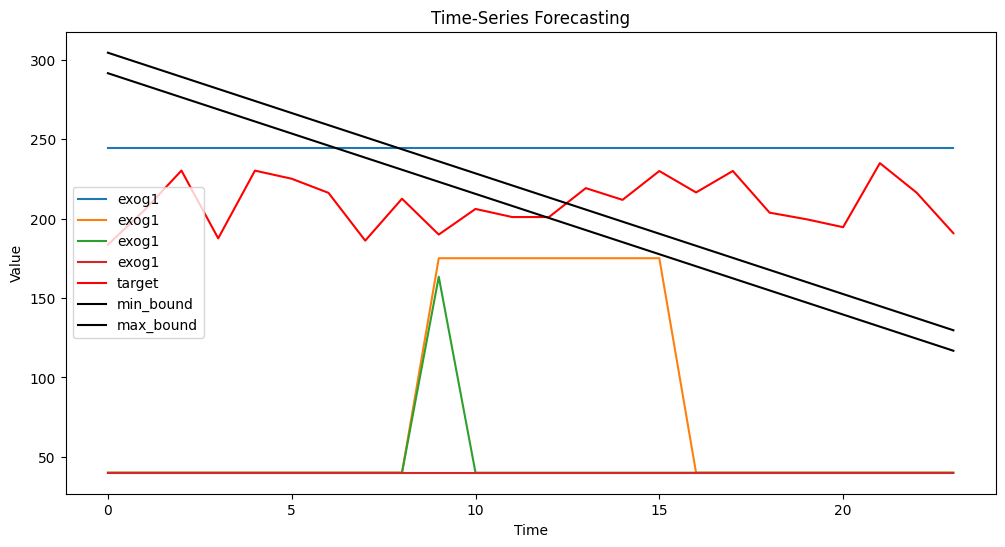

In [58]:
#PLOT
print(orig_train, orig_test)

plt.figure(figsize=(12,6))

X_test_exog = random.choice(dataset.X_test_exog)
for i in range(len(X_test_exog)):
    scaler = dataset.scaler[dataset.test_idxs[i]][TARGET_COL]
    X_test_exog_true = scaler.inverse_transform(X_test_exog)
plt.plot(X_test_exog_true, label='exog1')#data[look_back+1:][0]
plt.plot(Y_preds_original_gru, label='target', color='r')
plt.plot(min_bound_true, label='min_bound', color='black')
plt.plot(max_bound_true, label='max_bound', color='black')
#plt.plot(test, label='actual', color='g')
plt.xlabel('Time')
plt.ylabel('Value')
plt.title('Time-Series Forecasting')
plt.legend()
plt.show()
#Y_preds_original_gru, min_bound_true, max_bound_true


<Figure size 1200x600 with 0 Axes>

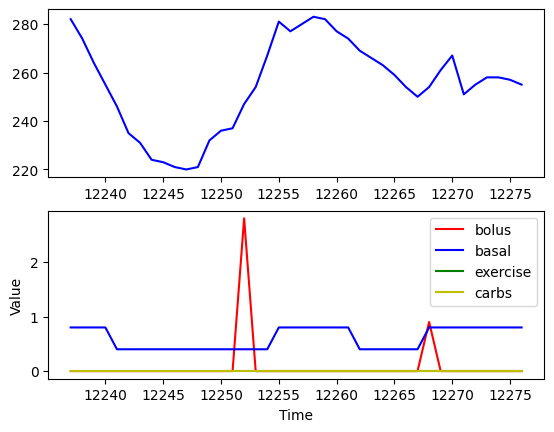

In [61]:
plt.figure(figsize=(12,6))
fig.suptitle('Data')
fig, (ax1, ax2) = plt.subplots(2)
plot_data = orig_train[orig_train.patient_id == 540]
ax1.plot(plot_data.glucose.tail(40), label='target', color='b')
ax2.plot(plot_data.bolus.tail(40), label='bolus', color='r')
ax2.plot(plot_data.basal.tail(40), label='basal', color='b')
ax2.plot(plot_data.exercise_intensity.tail(24), label='exercise', color='g')
ax2.plot(plot_data.carbs.tail(40), label='carbs', color='y')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()
fig.savefig('test.png')

In [ ]:
#OLD CODE

In [11]:
#statistical
from statsmodels.tsa.statespace.sarimax import SARIMAX

#orig_train = orig_train.dropna()
#orig_test = orig_test.dropna()
#endog = orig_train[orig_train.patient_id==544].glucose
#exog = orig_train[orig_train.patient_id==544].drop(['glucose', 'time', 'patient_id'], axis=1)
#exog_pred = orig_test[orig_test.patient_id==544].drop(['glucose', 'time', 'patient_id'], axis=1)
#endog_pred = orig_test[orig_test.patient_id==544].glucose
#print(orig_test, endog_pred)
#print(np.asarray(endog), np.asarray(exog))
print(y[0],X[0])
mod = sm.tsa.SARIMAX(endog=np.asarray(y[0]), exog=np.asarray(X[0]), order=(1,0,0))
#res = mod.fit(disp=False)
mod = mod.fit(disp=False)
start_params = mod.params
print(mod.summary())
pred = mod.forecast(horizon, start_params=start_params, exog=np.asarray(dataset.X_test_exog[0])[-horizon:])
print(pred)
max_iter = 100
it = 0
learning_rate = 0.0001
gradient=lambda v: 4 * v**3 - 10 * v - 3
exog_pred_change = np.asarray(dataset.X_test_exog[0])[-horizon:]
print("max_min", max_bound, min_bound)
while ((pred>max_bound).any() or (pred<min_bound).any()) and (it<max_iter):
    #change (X_e)
    print(it)
    diff = -learning_rate * gradient(exog_pred_change)
    exog_pred_change += diff
    it += 1
    pred = mod.forecast(horizon, start_params=start_params, exog=exog_pred_change)
    print(pred)
    
print(pred)

[[0.07598784]
 [0.06990881]
 [0.07902736]
 [0.09422492]
 [0.11550152]
 [0.15197568]
 [0.17933131]
 [0.21276596]
 [0.24620061]
 [0.27659574]
 [0.29483283]
 [0.30395137]
 [0.30395137]
 [0.31306991]
 [0.3100304 ]
 [0.29179331]
 [0.25835866]
 [0.2674772 ]
 [0.26443769]
 [0.2674772 ]
 [0.27051672]
 [0.27051672]
 [0.26443769]
 [0.25531915]] [[0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.45238095 0.48245614 0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.45238095 0.         0.         0.        ]
 [0.9047619  0.         0.         0.        ]
 [0.9047619  0.         0.         0.        ]
 [0.9047619  0.49122807 0.         0.        ]
 [0.9047619  0.49122807 0.         0.        ]
 [0.9047619  0.49122807 0.         0.        ]
 [0.9047619  0.49122807 0.         0.        ]
 [0.9

/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/mlemodel.py:3014: RuntimeWarning: invalid value encountered in divide
  return self.params / self.bse
/home/tomkemeyer/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['start_params']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                  59.406
Date:                Fri, 13 Dec 2024   AIC                           -106.811
Time:                        11:49:21   BIC                            -99.743
Sample:                             0   HQIC                          -104.936
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.0320      0.028      1.146      0.252      -0.023       0.087
x2            -0.0058      0.019     -0.312      0.755      -0.043       0.031
const               0         -0        nan        n

In [ ]:
#regression
import statsmodels.api as sm

def mean_squared_error(y_true, y_predicted):
    # Calculating the loss or cost
    cost = np.sum((y_true-y_predicted)**2) / len(y_true)
    return cost
    
orig_train = orig_train.dropna()
orig_test = orig_test.dropna()
endog = orig_train[orig_train.patient_id==591].glucose
exog = orig_train[orig_train.patient_id==591].drop(['glucose', 'time', 'patient_id'], axis=1)
exog_pred = orig_test[orig_test.patient_id==591].drop(['glucose', 'time', 'patient_id'], axis=1)
endog_pred = orig_test[orig_test.patient_id==591].glucose
print(orig_test, endog_pred)
print(np.asarray(endog), np.asarray(exog))
forest = sm.OLS(np.asarray(endog), np.asarray(exog)).fit()
pred = forest.predict(np.asarray(exog_pred))
print(pred)
max_iter = 100
it = 0
learning_rate = 0.0001
gradient=lambda v: 4 * v**3 - 10 * v - 3
exog_pred_change = np.asarray(exog_pred)
print("max_min", max_bound, min_bound)
while ((pred>max_bound).any() or (pred<min_bound).any()) and (it<max_iter):
    #change (X_e)
    print(it)
    diff = -learning_rate * gradient(exog_pred_change)
    exog_pred_change += diff
    it += 1
    pred = forest.predict(exog_pred_change)
    print(pred)
    
print(pred)